In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import xgboost as xgb
import shap

D:\App\Anaconda3\envs\test\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#读数据标准化划分数据集
df = pd.read_csv('../my_data.csv')
X = df.iloc[:, 1:58]
Y = df.iloc[:, 58:]
Y=Y['Band Gap (eV)']
names=df.columns
names=['SHAP value of '+x for x in names]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=10)
print("X_train's shape is", X_train.shape,"; y_train's shape is", y_train.shape)
print("X_test's shape is", X_test.shape,"; y_test's shape is",y_test.shape)
scaler = StandardScaler()
scaler.fit(X_train)
X_train_stand = scaler.transform(X_train)
X_test_stand = scaler.transform(X_test)

X_train's shape is (390, 57) ; y_train's shape is (390,)
X_test's shape is (98, 57) ; y_test's shape is (98,)


In [3]:
##best select model##
xgb_regressor = xgb.sklearn.XGBRegressor(n_estimators=200,
                                         colsample_bytree=0.5,
                                         gamma=0,
                                         learning_rate=0.15,
                                         max_depth=5,
                                         min_child_weight=7,
                                         reg_alpha=0,
                                         reg_lambda=1,
                                         subsample=0.7,
                                        )

model = xgb_regressor

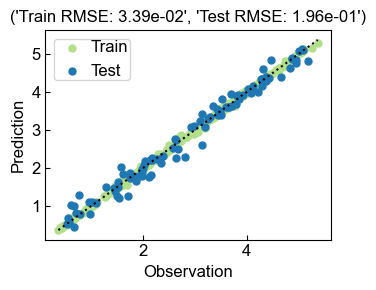

In [4]:
####fit and predict###
xgb_regressor.fit(X_train_stand, y_train)
y_train_hat = xgb_regressor.predict(X_train_stand)
y_test_hat = xgb_regressor.predict(X_test_stand)

# 将数据保存为 CSV 文件
train_df = pd.DataFrame({'y_train': y_train, 'y_train_hat': y_train_hat})
train_df.to_csv('./RMSE/Bg_train.csv', index=False)

test_df = pd.DataFrame({'y_test': y_test, 'y_test_hat': y_test_hat})
test_df.to_csv('./RMSE/Bg_test.csv', index=False)

###plot#####
fontsize = 12
plt.figure(figsize=(3.5,3))
plt.style.use('default')
plt.rc('xtick', labelsize=fontsize)
plt.rc('ytick', labelsize=fontsize)
plt.rcParams['font.family']="Arial"
a = plt.scatter(y_train, y_train_hat, s=25,c='#b2df8a')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k:', lw=1.5)
plt.xlabel('Observation', fontsize=fontsize)
plt.ylabel('Prediction', fontsize=fontsize)
plt.tick_params(direction='in')
plt.title(('Train RMSE: {:.2e}'.format(np.sqrt(metrics.mean_squared_error(y_train, y_train_hat))),\
               'Test RMSE: {:.2e}'.format(np.sqrt(metrics.mean_squared_error(y_test, y_test_hat)))), fontsize=fontsize)
b = plt.scatter(y_test, y_test_hat, s=25,c='#1f78b4')
plt.legend((a,b),('Train','Test'),fontsize=fontsize,handletextpad=0.1,borderpad=0.1)
plt.rcParams['font.family']="Arial"
plt.tight_layout()
plt.show()

In [5]:
import sklearn.metrics as metrics
from scipy.stats.stats import pearsonr

# Defining Metrics
def R2Score(X,Y):
    r2=metrics.r2_score(X,Y)
    return r2
#计算R²分数（R-squared score），也被称为决定系数，它衡量了回归模型对目标变量的方差解释比例。
#参数 X 和 Y 是两个数组，分别表示模型的预测值和实际目标值。

def PearsonCoefficient(X, Y):
    corr, _ = pearsonr(X,Y)
    return corr
#计算Pearson相关系数，衡量了两个变量之间的线性关系强度和方向。

In [6]:
PearsonCoefficient(y_test,y_test_hat)

0.9893940489712858

In [7]:
PearsonCoefficient(y_train,y_train_hat)

0.9996475109927656

In [8]:
R2Score(y_test,y_test_hat)

0.9788585534087972

In [9]:
R2Score(y_train,y_train_hat)

0.9992932211279181

In [10]:
import pandas as pd

# 读取原始 CSV 文件
df_new = pd.read_csv('Dec_data.csv')

# 在这里进行与训练数据相同的预处理
X_new = df_new.iloc[:, 1:58]  # 适当选择特征列
X_new_stand = scaler.transform(X_new)

# 使用模型进行预测
predictions = xgb_regressor.predict(X_new_stand)

# 将预测结果添加到原始数据框中
df_new['Band Gap (eV)'] = predictions

# 保存更新后的数据框到一个新的 CSV 文件
df_new.to_csv('Bg_data.csv', index=False)

In [11]:
####shap#####
model.fit(X, Y)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

print(shap_values.shape)

shap_explainer = explainer(X)
shap_explainer.base_values=shap_explainer.base_values[0]
shap_explainer.data=shap_explainer.data[0]
shap_explainer.values=shap_explainer.values[0]

(488, 57)


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


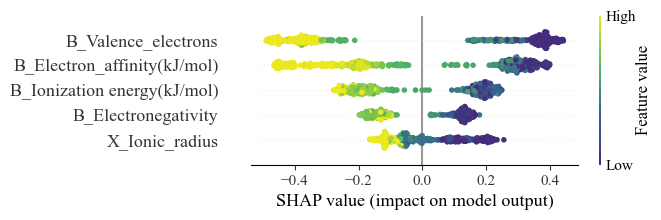

In [12]:
import numpy as np
from matplotlib import cm

# 定义两种颜色
color01 = (68,46,124)
color02 = (53,98,144)
color03 = (85,185,96)
color04 = (235,232,30)

# 将颜色值转换为0-1范围
colors = [tuple([x / 255 for x in color]) for color in [color01, color02, color03, color04]]

# 创建四种颜色之间的渐变
gradient_colors = [colors[0], colors[1], colors[2], colors[3]]


# 生成颜色渐变
n = 256
newcolors = []
for color in gradient_colors:
    rgba_color = cm.colors.to_rgba(color)
    newcolors.append(rgba_color)

newcmp = cm.colors.LinearSegmentedColormap.from_list('BlueYellow', newcolors, N=n)

# 设置全局字体和字号
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 50  # 字号

# 使用修改后的颜色渐变绘制图形
plt.figure()
shap.summary_plot(shap_values, X, max_display=5, show=False)
for fc in plt.gcf().get_children():
    for fcc in fc.get_children():
        if hasattr(fcc, "set_cmap"):
            fcc.set_cmap(newcmp)
# 保存图像
plt.tight_layout()
plt.savefig('./plot/Bg_summary_plot.tif', dpi=300, format='tif', bbox_inches='tight')

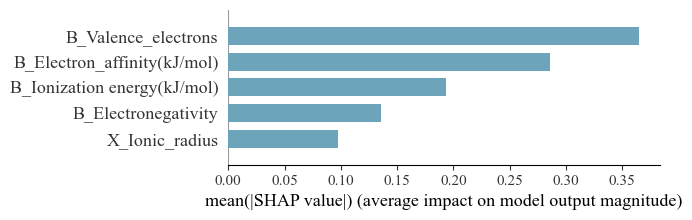

In [13]:
shap.summary_plot(shap_values, X, plot_type="bar", max_display=5, color='#6CA4BC', show=False)
# 保存图像
plt.tight_layout()
plt.savefig('./plot/Bg_summarybar_plot.tif', dpi=300, format='tif', bbox_inches='tight')

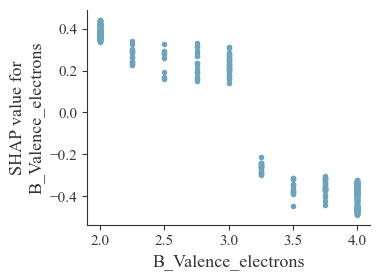

In [14]:
# 设置全局字体和字号
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 80  # 字号
shap.dependence_plot('B_Valence_electrons', shap_values, X, interaction_index=None, color='#6CA4BC', show=False)
# 保存图像
plt.tight_layout()
plt.savefig('./plot/Bg_dependence_plot_1.tif', dpi=300, format='tif', bbox_inches='tight')

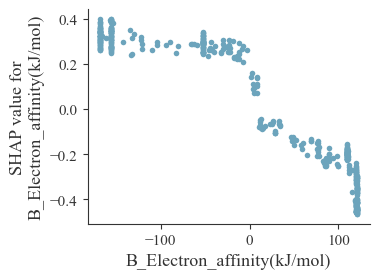

In [15]:
shap.dependence_plot('B_Electron_affinity(kJ/mol)', shap_values,X, interaction_index=None, color='#6CA4BC', show=False)
plt.tight_layout()
plt.savefig('./plot/Bg_dependence_plot_2.tif', dpi=300, format='tif', bbox_inches='tight')

In [16]:
# 设置全局字体和字号
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 50  # 字号
shap.plots.waterfall(shap_explainer, max_display=6, show=False)
# 保存图像
plt.tight_layout()
plt.savefig('./plot/Bg_waterfall_plot.pdf', dpi=300, format='pdf', bbox_inches='tight')